In [2]:
import os
import copy
import glob
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.nn.modules.activation import ReLU, Sigmoid
from torch.nn import Conv2d, modules
from torch.nn import Sequential

import torch.backends.cudnn as cudnn

In [24]:
# utils functions
def img_read(fPath, Gray=True):
    '''
    read the image given path "fPath"
    '''
    if Gray:
        return cv2.imread(fPath, -1)
    else:
        hr_img = cv2.imread(fPath)
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
    return hr_img

def getLR(hr_img, scale):
    '''
    bibubic downsmaple to get the corresponding low-resolution image by scaling factor "scale"
    '''
    h_orig = 0 
    w_orig = 0

    if len(hr_img.shape) == 2:
        h_orig, w_orig = hr_img.shape
    elif len(hr_img.shape) == 3:
        h_orig, w_orig, _ = hr_img.shape
    else:
        print("Image format is not correct")
        
    h, w = int(h_orig/scale), int(w_orig/scale)
    lr_img = cv2.resize(hr_img, (w, h), interpolation=cv2.INTER_NEAREST) # 30*30
    lr_img = cv2.resize(lr_img, (w_orig, h_orig), interpolation=cv2.INTER_CUBIC) # 120*120
    return lr_img

def computePSNR(img1, img2):
    '''
    compute PSNR(Peak Signal to Noise Ratio) to calculate accuracy
    img1 and img2 have range [0, 1], and both are gray level images
    '''
    if not img1.shape == img2.shape:
        print("Input images must have the same dimensions.")
    mse = torch.mean((img1-img2)**2)
    if mse == 0: # img1 and img2 are same images
        return float('inf')
    return 10.0 * torch.log10(1.0/mse)

In [11]:

class SRCNN(nn.Module):
    def __init__(self, num_channels=3):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, 
                               out_channels=64, 
                               kernel_size=9, 
                               padding=9 // 2)
        self.conv2 = nn.Conv2d(in_channels=64, 
                               out_channels=32, 
                               kernel_size=1, 
                               padding=5 // 2)
        self.conv3 = nn.Conv2d(in_channels=32, 
                               out_channels=num_channels, 
                               kernel_size=5, 
                               padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [12]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
def getPatches(dataRoot):
    '''
    get the list of patches sorted by order
    '''
    dataset = dataRoot
    patches = []
    for date in os.listdir(dataset):
        dateFolder = os.path.join(dataset, date)
        for patch in os.listdir(dateFolder):
            patches.append(os.path.join(dateFolder, patch))
    return patches


class SRData(Dataset):
    def __init__(self, imgFolder1, imgFolder2, unitSize, scale, Gray=True, transform=None):
        self.imgFolder1 = imgFolder1
        self.imgFolder2 = imgFolder2
        self.scale = scale
        self.unitSize = unitSize
        self.gray = Gray
        self.transform = transform
        self.folders1 = getPatches(imgFolder1)
        self.folders2 = getPatches(imgFolder2)
    
    def __getitem__(self, index):
        hr_img1 = img_read(self.folders1[index])
        hr_img2 = img_read(self.folders2[index])
        
        lr_img1 = getLR(hr_img1, scale=self.scale)
        
        lr_img1 = lr_img1[:, :, np.newaxis]
        hr_img1 = hr_img1[:, :, np.newaxis]
        hr_img2 = hr_img2[:, :, np.newaxis]
        
        input_img = np.concatenate((lr_img1, hr_img2), axis=2)
        label_img = np.concatenate((hr_img1, hr_img1), axis=2)
        
        #print(input_img.shape)
        #print(label_img.shape)
        
        if self.transform:
            input_img = self.transform(input_img)
            label_img = self.transform(label_img)
        return input_img, label_img

    def __len__(self):
        return len(self.images)
    
    


In [14]:
'''
hyper parameters
'''
torch.cuda.empty_cache()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cuda":
    print("cuda is available")
    cudnn.benchmark = True
else:
    print("cpu")

BATCH_SIZE = 16
NUM_WORKERS = 0
LR = 1e-4
EPOCHS = 200

IMG_FOLDER_SSH = "DATA/dataset-sst-ssh/ssh"
IMG_FOLDER_SST = "DATA/dataset-sst-ssh/sst"
UNIT_SIZE = 32

print(len(os.listdir(IMG_FOLDER_SSH)))
print(len(os.listdir(IMG_FOLDER_SST)))

SCALE = 3


verbose = 1




cuda is available
3734
3734


In [15]:
'''
prepare data
'''
# convert input to tensor
train_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0),(1.0, 1.0))
])

val_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0),(1.0, 1.0))
])

data = SRData(imgFolder1=IMG_FOLDER_SSH,
              imgFolder2=IMG_FOLDER_SST,
              unitSize=UNIT_SIZE, 
              scale=SCALE,
              Gray=True, 
              transform=train_transformer)

TRAIN_COUNT = 1500
EVAL_COUNT = 100
TEST_COUNT = 10
TRAIN_SIZE = TRAIN_COUNT * UNIT_SIZE
EVAL_SIZE = EVAL_COUNT * UNIT_SIZE
TEST_SIZE = TEST_COUNT * UNIT_SIZE

train_indices = torch.arange(TRAIN_SIZE)
val_indices = torch.arange(TRAIN_SIZE, TRAIN_SIZE+EVAL_SIZE)
test_indices = torch.arange(TRAIN_SIZE+EVAL_SIZE, TRAIN_SIZE+EVAL_SIZE+TEST_SIZE)

train_data = torch.utils.data.Subset(data, train_indices)
val_data = torch.utils.data.Subset(data, val_indices)
test_data = torch.utils.data.Subset(data, test_indices)

# data size 7 : 2 : 1
print("train set length: {}".format(int(len(train_data))))
print("val set length: {}".format(int(len(val_data))))
print("test set length: {}".format(int(len(test_data))))
# load data
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=True,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                            batch_size=1)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1)

train set length: 48000
val set length: 3200
test set length: 320


In [75]:
'''
training the SRCNN model
'''
from torch.utils.tensorboard import SummaryWriter

total_train_step = 0    # total training step
total_val_step = 0      # total validation step

# build model
srcnn = SRCNN(num_channels=2).to(DEVICE)
# loss function
loss_fn = nn.MSELoss()
#loss_fn = loss_fn.to(DEVICE)
# optimizer
optimizer = torch.optim.Adam([
    {'params': srcnn.conv1.parameters()},
    {'params': srcnn.conv2.parameters()},
    {'params': srcnn.conv3.parameters(),'lr': LR * 0.1}], lr=LR)
# learning rate scheduler
#scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5, verbose=True)
# visualize (tensorboard)
writer = SummaryWriter("ssh+sst_logs")

best_weights = copy.deepcopy(srcnn.state_dict())
best_epoch = 0
best_psnr = 0.0

torch.cuda.empty_cache()



with tqdm(total=EPOCHS) as t:   
    t.set_description("Progress: ")
    
    for i in range(EPOCHS):
        
        # training
        srcnn.train()
        epoch_losses = AverageMeter()
        
        #with tqdm(total=(len(train_data)-len(train_data)%BATCH_SIZE)) as t:
        #    t.set_description('epoch: {}/{}'.format(i+1, EPOCHS))
            
        for data in train_dataloader:
            
            # get data, transpose to device
            lr_imgs, hr_imgs = data
            lr_imgs = lr_imgs.to(DEVICE)
            hr_imgs = hr_imgs.to(DEVICE)
            
            # predict
            outputs = srcnn(lr_imgs)
            
            # calculate loss
            loss = loss_fn(outputs, hr_imgs)
            epoch_losses.update(loss.item(), len(lr_imgs))
            
            # optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # print loss
            t.set_postfix(loss='{:.6f}'.format(epoch_losses.avg))

            # show on tensorboard
            total_train_step += 1            
            if total_train_step%1000 == 0:
            #    print("train step: {}，Loss: {}".format(total_train_step, loss.item()))
                writer.add_scalar("train_loss", epoch_losses.avg, total_train_step)
            
            # update tqdm
            #t.update(len(lr_imgs))
        
            # scheduler
            #scheduler.step()

        # validation
        if (i+1) % verbose == 0:
        
            srcnn.eval()
            epoch_psnr = AverageMeter()
            
            for data in val_dataloader:
                
                # get data, transpose to device
                lr_imgs, hr_imgs = data
                lr_imgs = lr_imgs.to(DEVICE)
                hr_imgs = hr_imgs.to(DEVICE)
                
                # predict (no_grad) is important, not use to update model
                # cut compute graphe to reduce needed memory of device and 
                # accelerate the computation
                with torch.no_grad():
                    outputs = srcnn(lr_imgs).clamp(0.0, 1.0)
                
                # calculate psnr
                psnr = computePSNR(outputs, hr_imgs)
                epoch_psnr.update(psnr, len(lr_imgs))
                
                t.set_postfix(psnr='{:.4f}'.format(epoch_psnr.avg))
            
            # print psnr
            #t.write('eval PSNR: {:.4f}'.format(epoch_psnr.avg))
            
            # show in tensorboard
            total_val_step += verbose
            writer.add_scalar("eval_psnr", epoch_psnr.avg, total_val_step) 

            # save best weights
            if epoch_psnr.avg > best_psnr:
                best_epoch = i
                best_psnr = epoch_psnr.avg
                best_weights = copy.deepcopy(srcnn.state_dict())
                
            # update tqdm
            t.update(1)
        

# close tensorboard
writer.close()    
 



# save best model  
print('best epoch: {}, psnr: {:.4f}'.format(best_epoch, best_psnr))
torch.save(best_weights, "saved_models/srcnn_ssh+sst_{}.pth".format(best_epoch))
print("best model saved")



  0%|          | 0/200 [00:00<?, ?it/s]

best epoch: 197, psnr: 54.2357
best model saved


In [10]:
# load model

srcnn = SRCNN(num_channels=1).to('cpu')

state_dict = srcnn.state_dict()
for n, p in torch.load("saved_models/srcnn_ssh_x3.pth", map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)
    
print(srcnn)

#srcnn = torch.load("saved_models_2/srcnn_372.pth", map_location=torch.device('cpu'))
#print(srcnn)

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)


In [17]:
# load model

srcnn_ht = SRCNN(num_channels=2).to('cpu')

state_dict = srcnn_ht.state_dict()
for n, p in torch.load("saved_models/srcnn_ssh+sst_197.pth", map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)
    
print(srcnn_ht)


SRCNN(
  (conv1): Conv2d(2, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)


In [18]:
# numpy
def cal_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 1], and both are gray images
    if not img1.shape == img2.shape:
        print("Input images must have the same dimensions.")
    h,w = img1.shape
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]
    mse = np.mean(((img1-img2)*255)**2)
    if mse == 0:
        return float('inf')
    return 20*math.log10(255.0/math.sqrt(mse))

VSRnet PSNR:  51.520957946777344
SRCNN PSNR:  50.43468475341797
Bicubic PSNR:  44.36480876411341


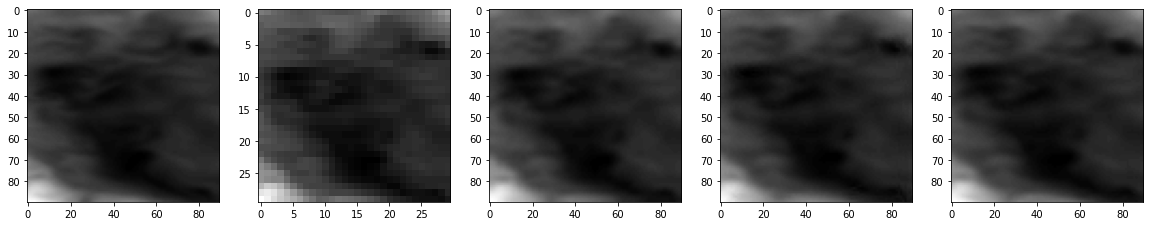

VSRnet PSNR:  55.02411651611328
SRCNN PSNR:  53.912933349609375
Bicubic PSNR:  41.56745505452005


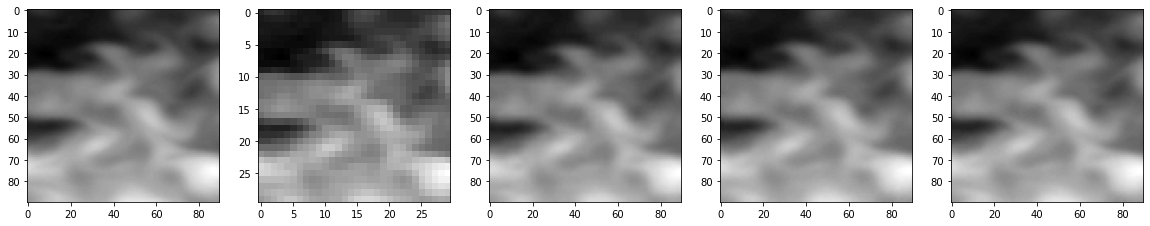

VSRnet PSNR:  49.67429733276367
SRCNN PSNR:  49.329776763916016
Bicubic PSNR:  33.59326132763706


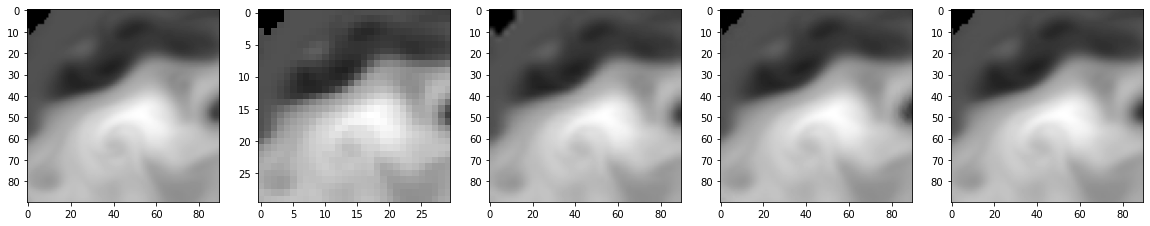

VSRnet PSNR:  53.946449279785156
SRCNN PSNR:  53.72655487060547
Bicubic PSNR:  41.063731123725944


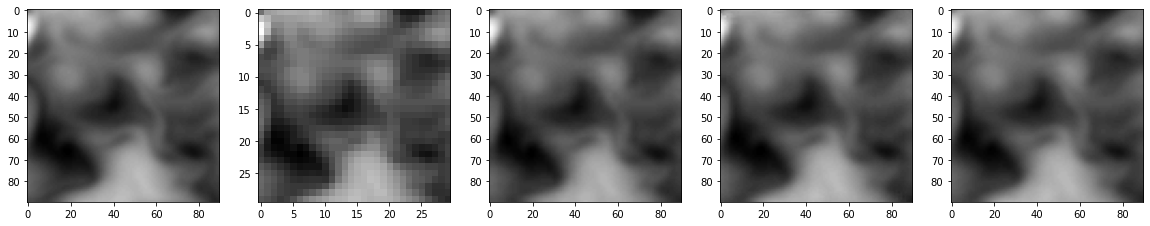

VSRnet PSNR:  52.24394989013672
SRCNN PSNR:  51.09814453125
Bicubic PSNR:  44.73935759067446


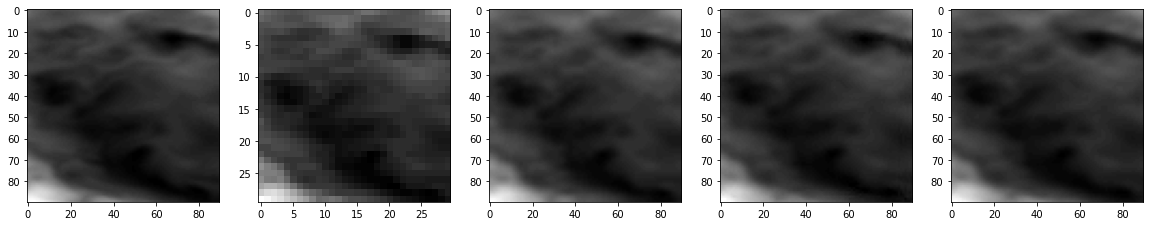

VSRnet PSNR:  54.171138763427734
SRCNN PSNR:  53.07604217529297
Bicubic PSNR:  41.64985501657491


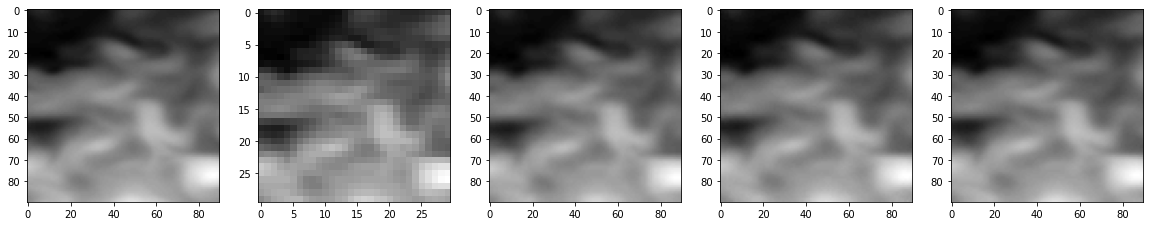

VSRnet PSNR:  52.44596481323242
SRCNN PSNR:  50.73394775390625
Bicubic PSNR:  33.60118982195202


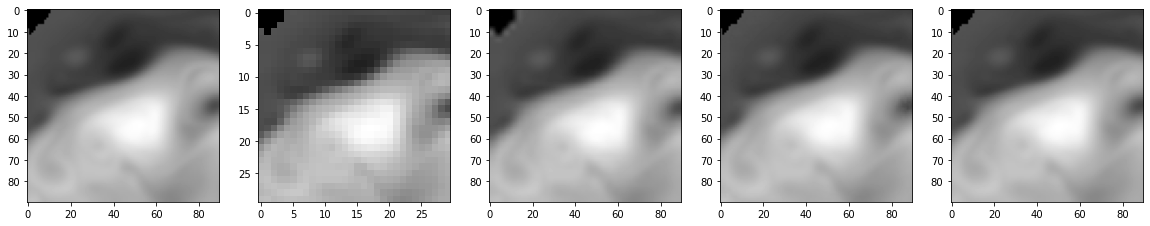

VSRnet PSNR:  55.17456817626953
SRCNN PSNR:  54.23505401611328
Bicubic PSNR:  41.705181448220074


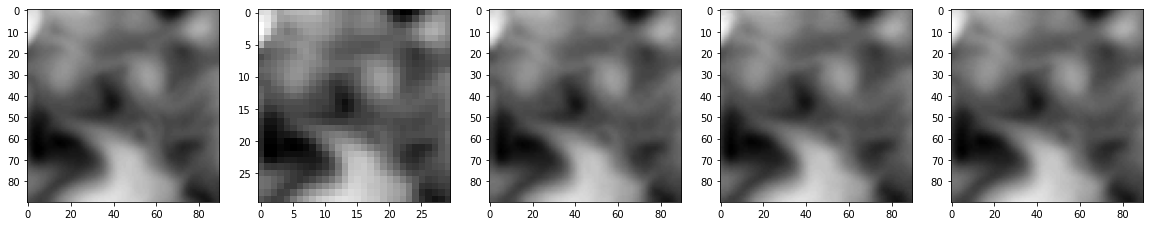

VSRnet Average PSNR:  54.499900817871094
SRCNN Average PSNR:  51.4537467956543
Bicubic Average PSNR:  41.88487528326091


In [23]:
# TEST

srcnn.eval()
srcnn_ht.eval()
bicubic_test_psnr = AverageMeter()
srcnn_ht_test_psnr = AverageMeter()
srcnn_test_psnr = AverageMeter()


count = 0
for data in test_dataloader:
    
    # get data, transpose to device
    input_imgs, target_imgs = data
    input_imgs = input_imgs.to('cpu')
    target_imgs = target_imgs.to('cpu')
    
    #print(sequence_imgs.shape)
    #print(sequence_imgs[:, [SEQUENCE_SIZE//2], :, :].shape)
    
    # predict (no_grad) is important, not use to update model
    # cut compute graphe to reduce needed memory of device and 
    # accelerate the computation
    with torch.no_grad():
        srcnn_ht_outputs = srcnn_ht(input_imgs).clamp(0.0, 1.0)
        srcnn_outputs = srcnn(input_imgs[:, [0], :, :]).clamp(0.0, 1.0)
        
    # calculate psnr
    srcnn_ht_psnr = computePSNR(srcnn_ht_outputs[:, [0], :, :], target_imgs[:, [0], :, :])
    srcnn_psnr = computePSNR(srcnn_outputs, target_imgs[:, [0], :, :])
    
    srcnn_ht_test_psnr.update(srcnn_ht_psnr, len(target_imgs))
    srcnn_test_psnr.update(srcnn_psnr, len(target_imgs))
    
    _,_, h,w = target_imgs.shape
    
    srcnn_ht_outputs = torch.reshape(srcnn_ht_outputs[:, [0], :, :], (1,h,w))
    srcnn_ht_output_imgs = transforms.ToPILImage()(srcnn_ht_outputs)
    
    #print(srcnn_outputs.shape)
    
    srcnn_outputs = torch.reshape(srcnn_outputs, (1,h,w))
    srcnn_output_imgs = transforms.ToPILImage()(srcnn_outputs)
    
    target_imgs = torch.reshape(target_imgs[:, [0], :, :], (1,h,w))
    target_imgs = transforms.ToPILImage()(target_imgs)
    
    lr_imgs = np.array(target_imgs)
    lr_imgs = cv2.resize(lr_imgs, (h//SCALE, w//SCALE), interpolation=cv2.INTER_NEAREST)
    
    bi_imgs = cv2.resize(lr_imgs, (h, w), interpolation=cv2.INTER_CUBIC)
    
    bicubic_psnr = cal_psnr(bi_imgs, np.array(target_imgs))
    bicubic_test_psnr.update(bicubic_psnr, 1)
    
    
    if count % 40 == 0:
        print("VSRnet PSNR: ", srcnn_ht_psnr.item())
        print("SRCNN PSNR: ", srcnn_psnr.item())
        print("Bicubic PSNR: ", bicubic_psnr)
        fig,axes = plt.subplots(1, 5, figsize=(20, 100)) # 1 lows, 2 cols
        axes[0].imshow(target_imgs, cmap='gray')
        axes[1].imshow(lr_imgs, cmap='gray')
        axes[2].imshow(bi_imgs, cmap='gray')
        axes[3].imshow(srcnn_output_imgs, cmap='gray')
        axes[4].imshow(srcnn_ht_output_imgs, cmap='gray')
        plt.show()
    count += 1

    
print("VSRnet Average PSNR: ", srcnn_ht_test_psnr.avg.item())
print("SRCNN Average PSNR: ", srcnn_test_psnr.avg.item())
print("Bicubic Average PSNR: ", bicubic_test_psnr.avg)